<h1>
<hr style=" border:none; height:3px;">
<center>SLICK - Post processing</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Clément VERON | Edouard SEGUIER</center></h4>

In [2]:
from PIL import Image
import numpy as np
import cv2
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt

# I - Clustering

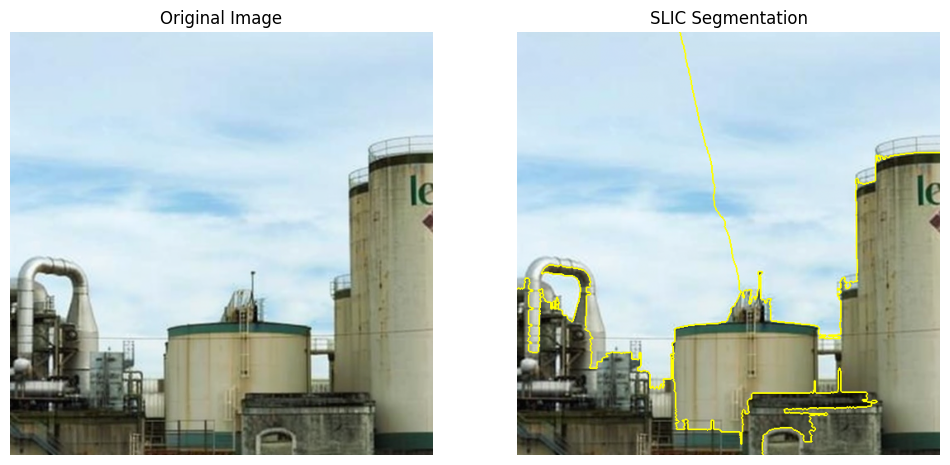

In [12]:
def segment_image_with_slic(image_path, n_segments=4, compactness=20):
    """
    Reads an image, applies SLIC segmentation, and clusters different squares.
    
    Parameters:
    - image_path (str): Path to the input image.
    - n_segments (int): The approximate number of superpixels (default is 4).
    - compactness (float): Balances color proximity and space proximity (default is 20).
    
    Returns:
    - None (displays the original image and the segmented image).
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return
    
    # Convert the image from BGR (OpenCV default) to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert the image to float format required by SLIC
    image_float = img_as_float(image_rgb)
    segments = slic(image_float, n_segments=n_segments, compactness=compactness, start_label=1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    ax[0].imshow(image_rgb)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    # Image with SLIC segmentation
    ax[1].imshow(mark_boundaries(image_rgb, segments))
    ax[1].set_title("SLIC Segmentation")
    ax[1].axis("off")
    
    plt.show()

# Example usage:
segment_image_with_slic("test_03_12/base.png", n_segments=5, compactness=30)

# II - Modification

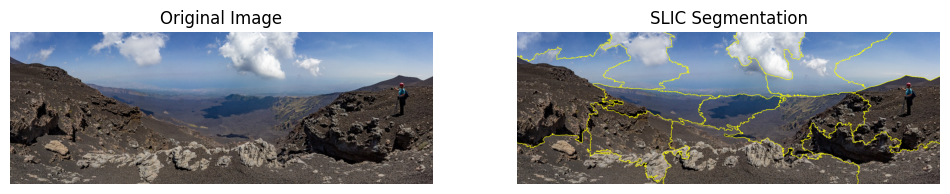

In [12]:
segment_image_with_slic("sicilia.jpg", n_segments=20, compactness=15)

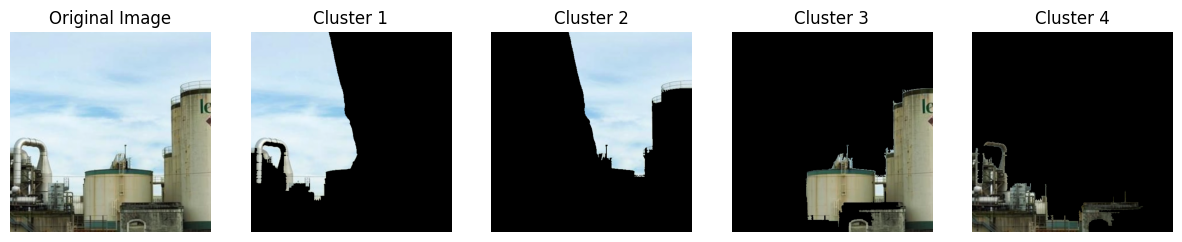

In [13]:
def segment_and_extract_clusters(image_path, n_segments=4, compactness=20):
    """
    Reads an image, applies SLIC segmentation, and extracts each segment as a separate image.
    
    Parameters:
    - image_path (str): Path to the input image.
    - n_segments (int): The approximate number of superpixels (default is 4).
    - compactness (float): Balances color proximity and space proximity (default is 20).
    
    Returns:
    - cluster_images (list): List of segmented cluster images (each as a NumPy array).
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return []
    
    # Convert the image from BGR (OpenCV default) to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert the image to float format required by SLIC
    image_float = img_as_float(image_rgb)
    
    # Perform SLIC segmentation
    segments = slic(image_float, n_segments=n_segments, compactness=compactness, start_label=1)
    
    # Extract individual clusters
    cluster_images = []
    for segment_label in np.unique(segments):
        # Create a mask for the current segment
        mask = segments == segment_label
        
        # Create a new image with the same dimensions, initially black
        segmented_image = np.zeros_like(image_rgb)
        
        # Copy the region corresponding to the current cluster into the new image
        segmented_image[mask] = image_rgb[mask]
        
        cluster_images.append(segmented_image)
    
    # Display the original image and segmented clusters
    fig, axes = plt.subplots(1, len(cluster_images) + 1, figsize=(15, 5))
    
    # Display original image
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Display segmented images
    for i, cluster_image in enumerate(cluster_images):
        axes[i + 1].imshow(cluster_image)
        axes[i + 1].set_title(f"Cluster {i + 1}")
        axes[i + 1].axis("off")
    
    plt.show()
    
    return cluster_images

# Example usage:
cluster_images = segment_and_extract_clusters("test_03_12/base.png", n_segments=5, compactness=30)

# III - Post processing

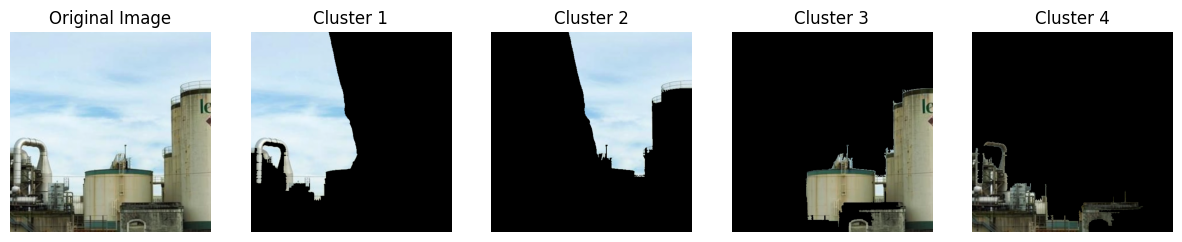

Saved cluster 1 to test_03_12/base\base_1.png
Saved cluster 2 to test_03_12/base\base_2.png
Saved cluster 3 to test_03_12/base\base_3.png
Saved cluster 4 to test_03_12/base\base_4.png


In [15]:
import os

def save_clusters_to_folder(cluster_images, output_folder="base"):
    """
    Saves each cluster image to a separate PNG file in a specified folder.
    
    Parameters:
    - cluster_images (list): List of cluster images (as NumPy arrays).
    - output_folder (str): Name of the folder to save the images (default is "base").
    
    Returns:
    - None
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Save each cluster image as a PNG file
    for i, cluster_image in enumerate(cluster_images):
        output_path = os.path.join(output_folder, f"base_{i + 1}.png")
        cv2.imwrite(output_path, cv2.cvtColor(cluster_image, cv2.COLOR_RGB2BGR))
        print(f"Saved cluster {i + 1} to {output_path}")

# Example usage with previously generated cluster images
cluster_images = segment_and_extract_clusters("test_03_12/base.png", n_segments=5, compactness=30)
save_clusters_to_folder(cluster_images, output_folder="test_03_12/base")


# IV - Reasemble the image

In [16]:
def reassemble_clusters_fixed(input_folder="base", output_file="new_base.png"):
    """
    Reassembles cluster images from a folder into a single image and saves it as a PNG file with correct colors.
    
    Parameters:
    - input_folder (str): Name of the folder containing cluster images (default is "base").
    - output_file (str): Name of the output file for the reassembled image (default is "new_base.png").
    
    Returns:
    - None
    """
    cluster_files = sorted(
        [f for f in os.listdir(input_folder) if f.endswith(".png")]
    )
    
    if not cluster_files:
        print(f"No PNG files found in {input_folder}.")
        return
    
    reassembled_image = None

    for cluster_file in cluster_files:
        cluster_path = os.path.join(input_folder, cluster_file)
        cluster_image = cv2.imread(cluster_path, cv2.IMREAD_UNCHANGED)
        
        if cluster_image is None:
            print(f"Error loading {cluster_path}. Skipping.")
            continue
        
        if reassembled_image is None:
            reassembled_image = np.zeros_like(cluster_image, dtype=np.uint8)
        
        reassembled_image = np.maximum(reassembled_image, cluster_image)
    
    cv2.imwrite(output_file, reassembled_image)
    print(f"Reassembled image saved as {output_file}")

# Example usage:
reassemble_clusters_fixed(input_folder="test_03_12/base", output_file="test_03_12/new_base.png")

Reassembled image saved as test_03_12/new_base.png


In [17]:
reassemble_clusters_fixed(input_folder="test_03_12/base_modified", output_file="test_03_12/post-ledits.png")

Reassembled image saved as test_03_12/post-ledits.png


# V - Post processing 

<div style="
    padding: 8px;
    border: 2px solid #f8d7da;
    border-radius: 5px;
    background-color: #f8d7da;
    color: #721c24;
    font-size: 14px;
    margin-bottom: 10px;
    max-width: 1125px;">
    <strong>⚠️ Note:</strong> The frontiers between each cluster are a bit unnatural, justifying the need of a post processing step
</div>

In [8]:
import cv2
import numpy as np

image_path = 'test_2.png'
image = cv2.imread(image_path)

def blur_frontiers(image, kernel_size=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    blurred = cv2.GaussianBlur(mask, (kernel_size, kernel_size), 0)
    blended = cv2.bitwise_and(image, image, mask=blurred)
    return blended

def fill_black_spaces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    inverted_mask = cv2.bitwise_not(mask)
    inpainted = cv2.inpaint(image, inverted_mask, 3, cv2.INPAINT_TELEA)
    return inpainted

blurred_image = blur_frontiers(image)
final_image = fill_black_spaces(blurred_image)

final_image_path = 'post_processed_test2.png'
cv2.imwrite(final_image_path, final_image)


True